This is an example of developing a script locally with the West Nile Virus data to share on Kaggle
Once you have a script you're ready to share, paste your code into a [new script](https://www.kaggle.com/c/predict-west-nile-virus/scripts/new).

In [69]:
# For working locally, you want to be in west_nile_scripts/working. 
# This command will move you to there, if you're in west_nile_scripts/src (where this file is).
!cd ../working/ # Not necessary for scripts running on Kaggle

In [320]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
#Remove this when copying to a script on Kaggle:
%matplotlib inline
import datetime as dt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [321]:


mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../input/train.csv')[['Date', 'Species','Trap','Longitude', 'Latitude', 
                                           'NumMosquitos','WnvPresent']]
weather = pd.read_csv('../input/weather.csv').drop(["CodeSum", "Depth", "Water1", "SnowFall",
                                                    "SeaLevel", "ResultDir", "ResultSpeed",
                                                    "AvgSpeed", "StnPressure"], 1)
spray = pd.read_csv('../input/spray.csv')
samplesub = pd.read_csv('../input/sampleSubmission.csv')
test = pd.read_csv('../input/test.csv')

# aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
# lon_lat_box = (-88, -87.5, 41.6, 42.1)

# plt.figure(figsize=(10,14))
# plt.imshow(mapdata, 
#            cmap=plt.get_cmap('gray'), 
#            extent=lon_lat_box, 
#            aspect=aspect)

# locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
# plt.scatter(locations[:,0], locations[:,1], marker='x')

# Add this when copying to a script on Kaggle:
#plt.savefig('heatmap.png')

## Traps data cleaning

In [202]:
traps.head(3)

,Date,Species,Trap,Longitude,Latitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,-87.800991,41.954690,1,0
1,2007-05-29,CULEX RESTUANS,T002,-87.800991,41.954690,1,0
2,2007-05-29,CULEX RESTUANS,T007,-87.769279,41.994991,1,0


In [323]:
# Traps df cleaning
# Convert to date to date time
traps.Date = pd.to_datetime(traps.Date)
weather.Date = pd.to_datetime(weather.Date)
# Convert lat&long, num mosquitoes and WnvPResent to numeric
for i in range(3,len(traps.columns)):
    traps.iloc[:, i] = pd.to_numeric(traps.iloc[:, i], errors="coerce")

# Weather df cleaning
# Converts T(trace) to low value of 0.001, and converts "M" (missing data) to NaN
weather["PrecipTotal"] = pd.to_numeric(weather.PrecipTotal.str.strip().replace("T",0.001),
                                      errors="coerce")
# Depart, Cool, Sunrise & Sunset, and PrecipTotal have Missing values
# Convert to numeric first, then forward fill NaN
for i in range(2,len(weather.columns)):
    weather.iloc[:, i] = pd.to_numeric(weather.iloc[:, i], errors="coerce")
# Impute missing values for the weather with forward fill()
weather.fillna(method='ffill',inplace=True)

In [205]:
traps.isnull().sum()

Date            0
Species         0
Trap            0
Longitude       0
Latitude        0
NumMosquitos    0
WnvPresent      0
dtype: int64

In [324]:
def closer_station(lat,long):
    loc = np.array([lat,long])
    # station 1: [41.995, -87.933], station 2: [41.786, -87.752]
    stations = np.array([[41.995, -87.933],
                         [41.786, -87.752]])
    # get the station # with the lower distance squared
    return np.argmin(((stations-loc[None,:])**2).sum(1))+1

In [325]:
def merge_station(traps):
    station_list= []
    for i in range(len(traps)):
        station_dict = {'Trap':traps.loc[i, "Trap"],'Station': closer_station(
                traps.loc[i,"Latitude"], traps.loc[i, "Longitude"])}
        if station_dict not in station_list:
            station_list.append(station_dict) 
    return traps.merge(pd.DataFrame(station_list),on="Trap",how="inner")
trap_stations = merge_station(traps).drop(["Longitude","Latitude"],1)
trap_stations.head()

,Date,Species,Trap,NumMosquitos,WnvPresent,Station
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,1,0,1
1,2007-05-29,CULEX RESTUANS,T002,1,0,1
2,2007-06-05,CULEX PIPIENS/RESTUANS,T002,3,0,1
3,2007-06-05,CULEX RESTUANS,T002,5,0,1
4,2007-06-05,CULEX PIPIENS,T002,1,0,1


In [268]:
trap_stations.Date[0].month,trap_stations.Date[0].day

(5, 29)

In [326]:
#len(traps)
trap_stations.head(7)

,Date,Species,Trap,NumMosquitos,WnvPresent,Station
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,1,0,1
1,2007-05-29,CULEX RESTUANS,T002,1,0,1
2,2007-06-05,CULEX PIPIENS/RESTUANS,T002,3,0,1
3,2007-06-05,CULEX RESTUANS,T002,5,0,1
4,2007-06-05,CULEX PIPIENS,T002,1,0,1
5,2007-06-26,CULEX PIPIENS/RESTUANS,T002,1,0,1
6,2007-06-26,CULEX RESTUANS,T002,4,0,1


In [327]:
trap_stations.merge(weather,on=["Date","Station"],how="inner")

,Date,Species,Trap,NumMosquitos,WnvPresent,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,1,0,1,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.000
1,2007-05-29,CULEX RESTUANS,T002,1,0,1,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.000
2,2007-05-29,CULEX RESTUANS,T007,1,0,1,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.000
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,1,0,1,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.000
4,2007-05-29,CULEX RESTUANS,T015,4,0,1,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.000
5,2007-05-29,CULEX PIPIENS/RESTUANS,T143,1,0,1,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.000
6,2007-06-05,CULEX PIPIENS/RESTUANS,T002,3,0,1,64,47,56.0,-9.0,48,51.0,9.0,0.0,417.0,1923.0,0.420
7,2007-06-05,CULEX RESTUANS,T002,5,0,1,64,47,56.0,-9.0,48,51.0,9.0,0.0,417.0,1923.0,0.420
8,2007-06-05,CULEX PIPIENS,T002,1,0,1,64,47,56.0,-9.0,48,51.0,9.0,0.0,417.0,1923.0,0.420
9,2007-06-05,CULEX PIPIENS/RESTUANS,T015,1,0,1,64,47,56.0,-9.0,48,51.0,9.0,0.0,417.0,1923.0,0.420


In [154]:
#weather.isnull().sum()
1472/4

368.0

In [57]:
# Compute 

In [68]:
#Depart, Cool, Sunrise & Sunset, and PrecipTotal have Missing values
weather.Tavg.unique()

array(['67', '68', '51', '52', '56', '58', 'M', '60', '59', '65', '70',
       '69', '71', '61', '55', '57', '73', '72', '53', '62', '63', '74',
       '75', '78', '76', '77', '66', '80', '64', '81', '82', '79', '85',
       '84', '83', '50', '49', '46', '48', '45', '54', '47', '44', '40',
       '41', '38', '39', '42', '37', '43', '86', '87', '89', '92', '88',
       '91', '93', '94', '90', '36'], dtype=object)

In [171]:
traps.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [305]:
traps_2009 = traps[(traps.Date < dt.date(2010,1,1)) & (traps.Date > dt.date(2009,1,1))]
traps_2011 = traps[(traps.Date < dt.date(2012,1,1)) & (traps.Date > dt.date(2011,1,1))]
weather_2011 = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))]

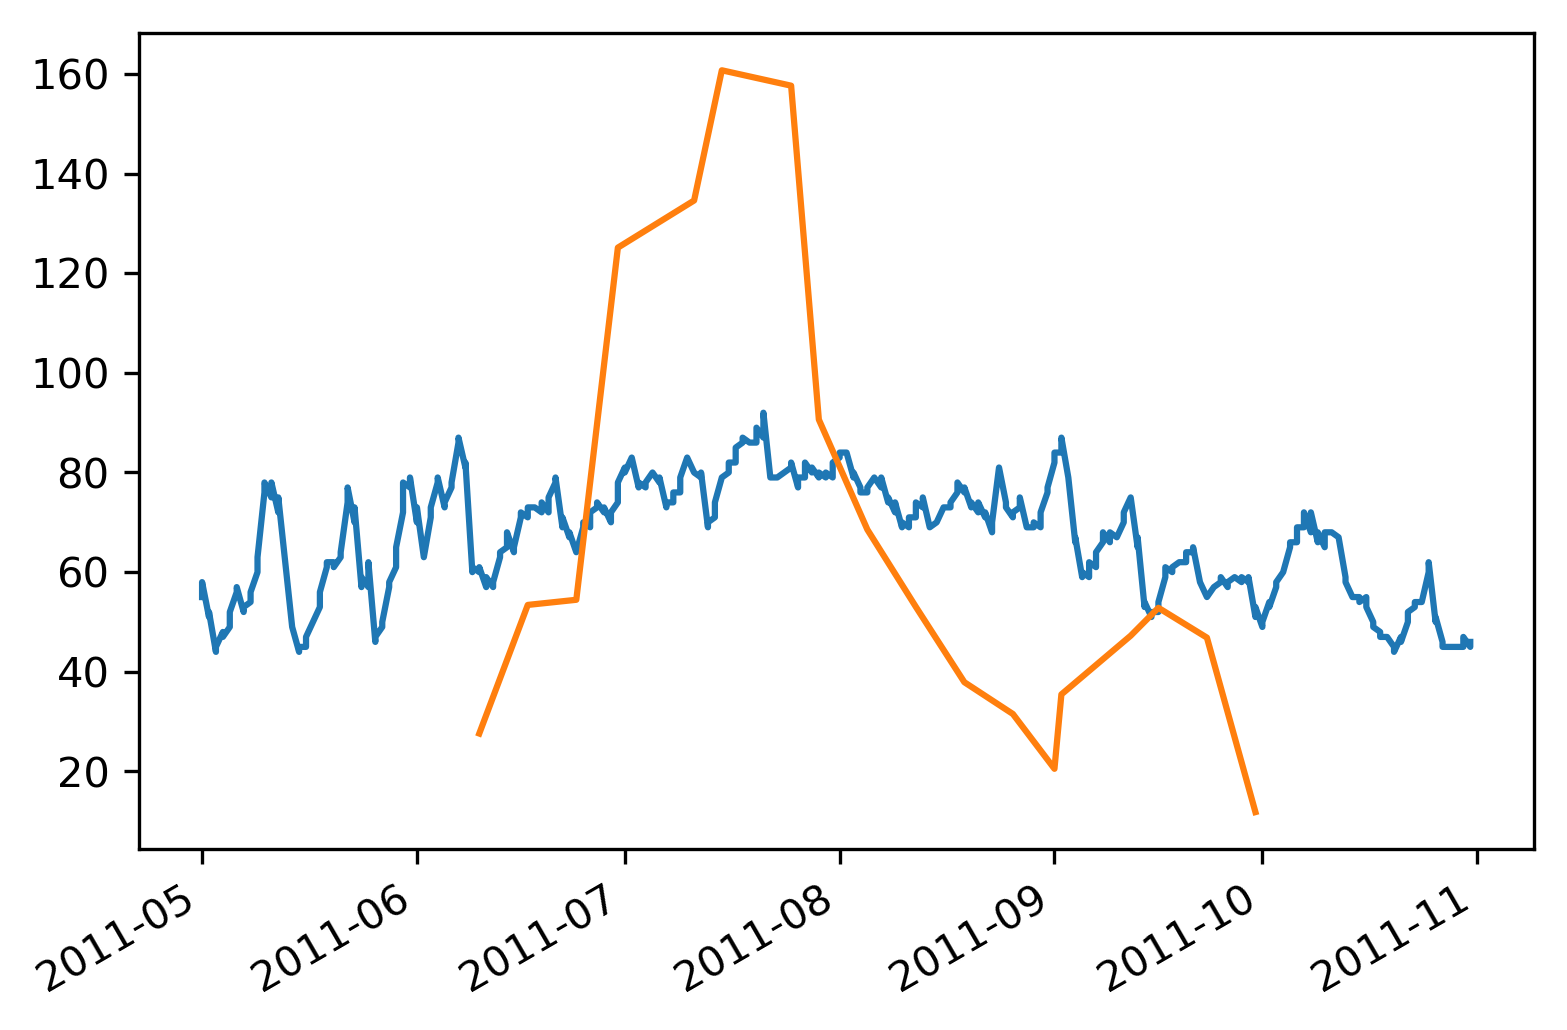

In [284]:
# dates = dates.date2num(weather.Date)
# plt.plot_date(dates, weather.Tavg)
plt.plot(weather[(weather.Date < dt.date(2012,1,1)) & 
                 (weather.Date > dt.date(2011,1,1))].Date,
        weather[(weather.Date < dt.date(2012,1,1)) & 
                (weather.Date > dt.date(2011,1,1))].Tavg)

plt.plot(traps_2011.groupby('Date').agg('sum').index, 
         traps_2011.groupby('Date').agg('sum').NumMosquitos/Scale)
plt.gcf().autofmt_xdate()

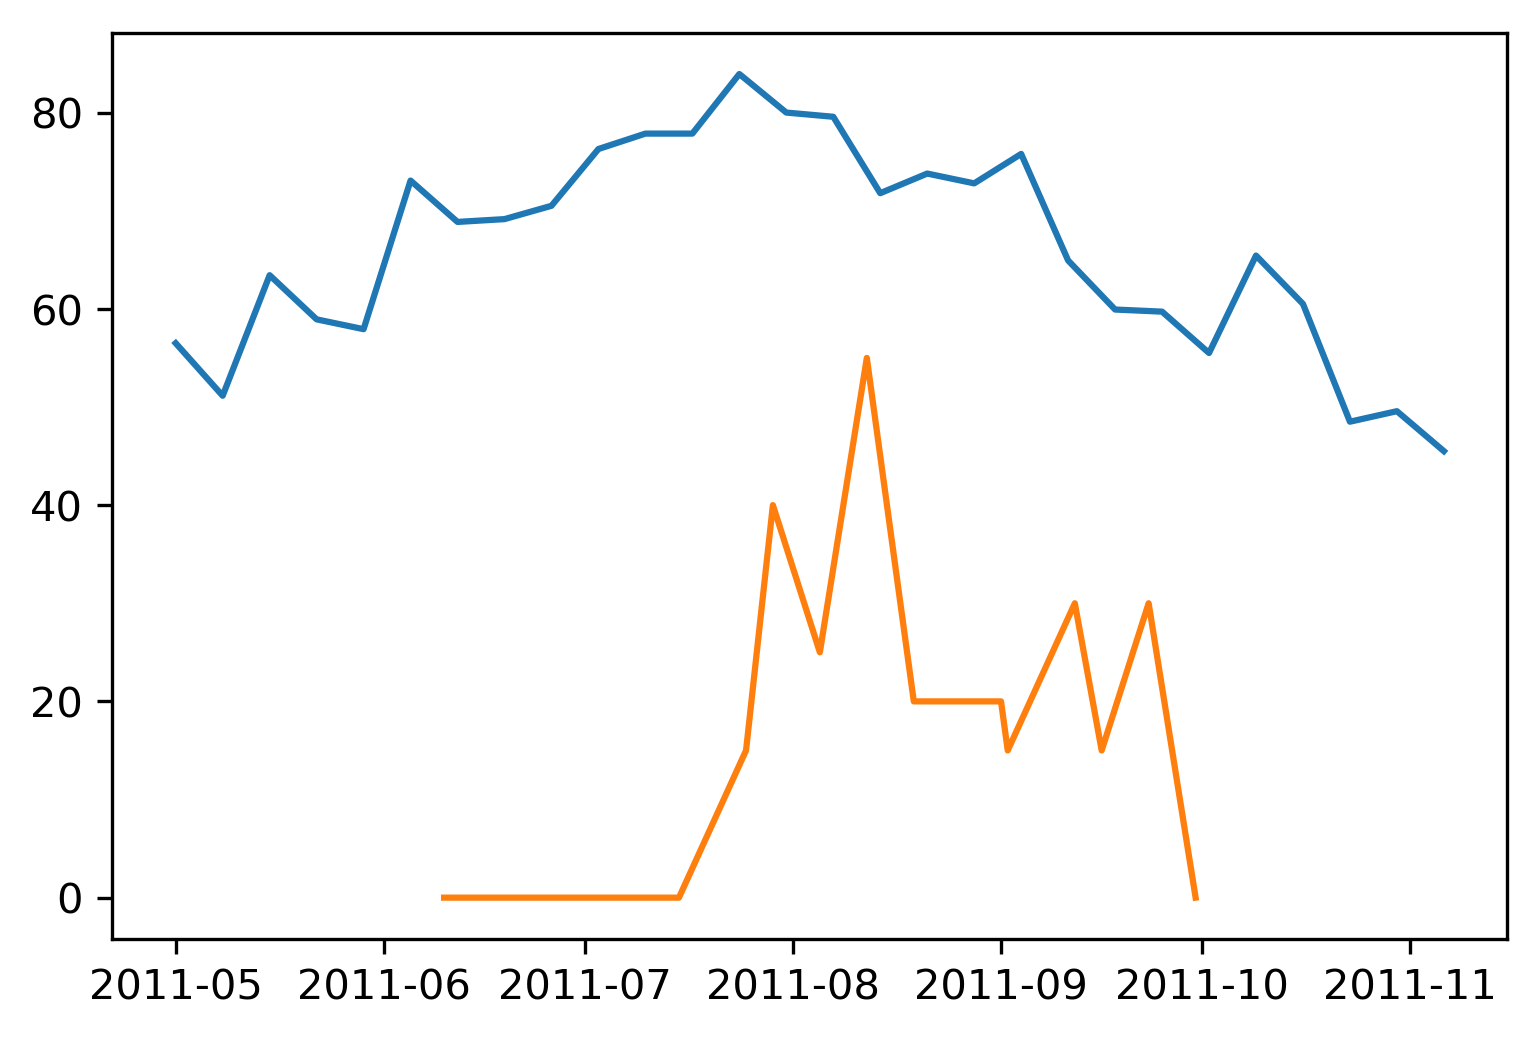

In [313]:

weather2 = weather.set_index("Date")
weekly_2011 = weather_2011.set_index("Date").Tavg.resample('W').mean()
plt.plot(weekly_2011)
plt.plot(traps_2011.groupby('Date').agg('sum').index, 
         traps_2011.groupby('Date').agg('sum').WnvPresent*5)


In [297]:
weather[weather.Date > dt.date(2007,10,25)]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal
356,1,2007-10-26,65,53,59.0,11.0,48,52.0,6.0,0.0,617.0,1654.0,0.330
357,2,2007-10-26,66,53,60.0,11.0,49,52.0,5.0,0.0,617.0,1654.0,0.410
358,1,2007-10-27,55,37,46.0,-2.0,38,45.0,19.0,0.0,618.0,1653.0,0.010
359,2,2007-10-27,57,39,48.0,-2.0,41,46.0,17.0,0.0,618.0,1653.0,0.080
360,1,2007-10-28,56,34,45.0,-2.0,30,39.0,20.0,0.0,619.0,1651.0,0.000
361,2,2007-10-28,56,34,45.0,-2.0,30,39.0,20.0,0.0,619.0,1651.0,0.000
362,1,2007-10-29,61,39,50.0,3.0,32,42.0,15.0,0.0,620.0,1650.0,0.000
363,2,2007-10-29,60,39,50.0,3.0,32,42.0,15.0,0.0,620.0,1650.0,0.000
364,1,2007-10-30,66,41,54.0,8.0,38,46.0,11.0,0.0,622.0,1649.0,0.000
365,2,2007-10-30,66,42,54.0,8.0,37,46.0,11.0,0.0,622.0,1649.0,0.000


In [283]:
Scale = traps_2011.groupby('Date').agg('sum').NumMosquitos.mean()/weather.Tavg.mean()
#weather.Tavg.mean()
Scale

15.536067066632082

In [110]:
traps_2011.groupby('Date').agg('sum').index, traps_2011.groupby('Date').agg('sum').WnvPresent

(DatetimeIndex(['2011-06-10', '2011-06-17', '2011-06-24', '2011-06-30',
                '2011-07-11', '2011-07-15', '2011-07-25', '2011-07-29',
                '2011-08-05', '2011-08-12', '2011-08-19', '2011-08-26',
                '2011-09-01', '2011-09-02', '2011-09-12', '2011-09-16',
                '2011-09-23', '2011-09-30'],
               dtype='datetime64[ns]', name='Date', freq=None), Date
 2011-06-10     0
 2011-06-17     0
 2011-06-24     0
 2011-06-30     0
 2011-07-11     0
 2011-07-15     0
 2011-07-25     3
 2011-07-29     8
 2011-08-05     5
 2011-08-12    11
 2011-08-19     4
 2011-08-26     4
 2011-09-01     4
 2011-09-02     3
 2011-09-12     6
 2011-09-16     3
 2011-09-23     6
 2011-09-30     0
 Name: WnvPresent, dtype: int64)

In [111]:
traps_2011.groupby('Date').agg('sum').WnvPresent

Date
2011-06-10     0
2011-06-17     0
2011-06-24     0
2011-06-30     0
2011-07-11     0
2011-07-15     0
2011-07-25     3
2011-07-29     8
2011-08-05     5
2011-08-12    11
2011-08-19     4
2011-08-26     4
2011-09-01     4
2011-09-02     3
2011-09-12     6
2011-09-16     3
2011-09-23     6
2011-09-30     0
Name: WnvPresent, dtype: int64

In [77]:
weather[(weather.Date < dt.date(2010,1,1)) & (weather.Date > dt.date(2009,1,1))].Date.head()

736   2009-05-01
737   2009-05-01
738   2009-05-02
739   2009-05-02
740   2009-05-03
Name: Date, dtype: datetime64[ns]

In [216]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [79]:
traps_2009.groupby('Date').agg('sum').index

DatetimeIndex(['2009-05-28', '2009-06-02', '2009-06-03', '2009-06-05',
               '2009-06-12', '2009-06-15', '2009-06-19', '2009-06-22',
               '2009-06-26', '2009-06-29', '2009-07-06', '2009-07-10',
               '2009-07-13', '2009-07-17', '2009-07-24', '2009-07-27',
               '2009-07-31', '2009-08-07', '2009-08-13', '2009-08-25',
               '2009-08-27', '2009-09-03', '2009-09-14', '2009-09-17',
               '2009-09-25', '2009-10-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [116]:
# import numpy as np
# from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt

# # xi = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg
# # # use fitpack2 method
# # ius = InterpolatedUnivariateSpline(weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Date,
# #         weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg)
# # yi = ius(xi)

# # import statsmodels.api as sm
# # sm.tsa.seasonal_decompose(weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg).plot()
# # result = sm.tsa.stattools.adfuller(weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Date)
# # plt.show()
# Tavg = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg
# Date = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Date
# Date.corr(Tavg)